In [2]:
import numpy as np
import matplotlib.pyplot as plt
from diffpy.mpdf import *
from scipy.optimize import least_squares
from glob import glob
from diffpy.structure import loadStructure

#%matplotlib notebook

In [3]:
def ssf(r,d):
    f = 1 - 3*r/(2*d)+0.5*(r/d)**3
    f[r>d] = 0
    return f

In [4]:
# Define the wave function that arises from solvent-particle interaction in the sample

def npwave(r, amp, omega, phi, delta):
    """Dampened sine-wave from Sasu. 
    """
    ysin = np.sin(r*omega - phi)
    yexp = np.exp(-delta*r)
    rv = amp * ysin * yexp
    return rv

In [5]:
def getDiffData(fileName, fitIdx=0, writedata=False, skips=12):
    """Extract the fit residual from a structural PDF fit. Works for .fgr and
       .ddp files.
    Args:
        fileName (str): path to the .fgr or .ddp file containing the fit
        fitIdx (int): index of fit in .ddp file from which the residual
             is to be extracted.
        writedata (boolean): whether or not the output should be saved to file
        skips (int): Number of rows to be skipped in .fgr file to get to data;
            default is 14.
    Returns:
        r (numpy array): same r-grid as contained in the fit file
        diff (numpy array): the structural PDF fit residual (i.e. the mPDF)
    """
    if fileName[-4:] == '.fgr':
        allcols = np.loadtxt(fileName, unpack=True, comments='#', skiprows=skips)
        r, diff = allcols[0], allcols[4]
        if writedata:
            np.savetxt(fileName[:-4] + '.diff', np.transpose((r, diff)))
        return r, diff
    elif fileName[-4:] == '.ddp':
        from diffpy.pdfgui import tui
        prj = tui.LoadProject(fileName)
        fit = prj.getFits()[fitIdx]
        dataSet = fit.getDataSet(0)
        r = np.array(dataSet.rcalc)
        diff = np.array(dataSet.Gdiff)
        if writedata:
            np.savetxt(fileName[:-4] + '_' + str(fitIdx) + '.diff',
                       np.transpose((r, diff)))
        return r, diff
    else:
        print('This file format is not currently supported.')
        return np.array([0]), np.array([0])

In [6]:

def cv(x1, y1, x2, y2):
    """Perform the convolution of two functions and give the correct output.
    Args:
        x1 (numpy array): independent variable of first function; must be in
            ascending order
        y1 (numpy array): dependent variable of first function
        x2 (numpy array): independent variable of second function; must have
            same grid spacing as x1
        y2 (numpy array): dependent variable of second function
    Returns:
        xcv (numpy array): independent variable of convoluted function, has
            dimension len(x1) + len(x2) - 1
        ycv (numpy array): convolution of y1 and y2, same shape as xcv
    """
    dx = x1[1] - x1[0]
    ycv = dx * convolve(y1, y2, 'full')
    xcv = np.linspace(x1[0] + x2[0], x1[-1] + x2[-1], len(ycv))
    return xcv, ycv

In [7]:
def smoothData(xdata, ydata, qCutoff, func='sinc', gaussHeight=0.01):
    """Smooth out high-frequency contributions from the data.
    This method performs a convolution in real space to simulate a truncation
    in reciprocal space. This is motivated by the fact that high-frequency
    noise can sometimes obscure the lower-frequency mPDF signal when the mPDF
    is collected together with the nuclear PDF. This high-frequency noise comes
    from scattering intensity at high q that cannot possibly come from magnetic
    scattering, due to the strong suppression from the magnetic form factor.
    To better isolate the mPDF from this high-frequency noise, one could
    truncate the Fourier transfrom at some cutoff q value beyond which the
    magnetic scattering is negligible (e.g. where the square of the magnetic
    form factor is reduced to 1% of its original value). This can be done by
    multiplying the scattering in q-space by a "window function" that is equal
    to unity for q between 0 and the cutoff value and 0 outside this window.
    By the convolution theorem, this is equivalent to convoluting the full
    Fourier transform in real space with a sinc function. Alternatively, one
    could multiply the scattering in q-space by a Guassian function which is
    reduced to some small amplitude at the desired cutoff q value.  This is
    equivalent to a convolution in real space with another Gaussian function.
    The former method is recommended because it will generally be more
    physically justifiable.
    Args:
        xdata: numpy array containing the independent variable of the data
            to be smoothed.
        ydata: numpy array containing the dependent variable; this array will
            be smoothed.
        qCutoff: q value beyond which all contributions will be ignored.
        func: string specifying the type of real-space convolution function,
            either 'sinc' or 'gaussian' (see previous discussion).
        gaussHeight: float specifying what the height of the q-space Gaussian
            function should be at the specified value of qCutoff.
    Returns:
        Numpy array containing the smoothed version of ydata.
    """
    dr = np.mean((xdata - np.roll(xdata, 1))[1:])
    rs = np.arange(-10, 10, dr)
    if func == 'sinc':
        s = np.sinc(rs * qCutoff / np.pi)
    elif func == 'gaussian':
        rg = 1.0 / (qCutoff * np.sqrt(np.log(1.0 / gaussHeight) / 2.0))
        s = np.exp(-rs ** 2 / 2.0 / rg ** 2)
    else:
        print('The only function options are sinc and gaussian. Please check')
        print('your input. Using sinc by default.')
        s = np.sinc(rs * qCutoff / np.pi)
    xsmooth, ysmooth = cv(xdata, ydata, rs, s)
    ysmooth /= np.trapz(s, rs)
    msk = np.logical_and(xsmooth > (xdata.min() - 0.5 * dr), xsmooth < (xdata.max() + 0.5 * dr))
    return ysmooth[msk]

the magnetic species. calcIdxs should have the index of
at least one spin from each species. Use
magStruc.getSpeciesIdxs() to see starting indices for
each species.



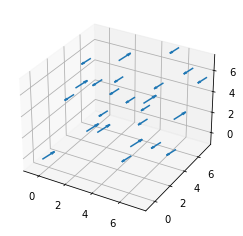

{'A': 0, 'B': 86215}
desired calculation range.


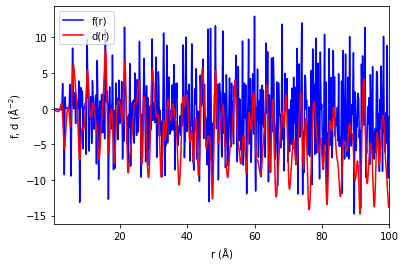

In [11]:
rexp,dexp = getDiffData('NOM_9999_DryPowder2_50_ff_ftfrgr.gr.fgr')
dexpSmooth = smoothData(rexp,dexp,8.0)
struc = loadStructure('Drypowder_cubic.stru')
occ = 0.7610
lat = struc.lattice

#svec = np.array([0,0,1.0]) ### Note: direction will make a slight difference for this tetragonal structure
th0,phi0 = np.pi/2.0, 0.0
svec = np.array([1,1,1])/np.sqrt(3)
msp1 = MagSpecies(struc,strucIdxs=range(8),ffparamkey='Fe3',rmaxAtoms=100,kvecs=np.array([0,0,0]),
                 basisvecs=svec,label='A')
msp2 = MagSpecies(struc,strucIdxs=np.arange(16)+8,ffparamkey='Fe3',rmaxAtoms=100,kvecs=np.array([0,0,0]),
                 basisvecs=-occ*svec,label='B')
mstr = MagStructure()
mstr.loadSpecies(msp1)
mstr.loadSpecies(msp2)
mstr.makeAll()

### Visualize the magnetic structure
uc = struc[:24].xyz
visatoms = uc.copy()
visatoms = struc.lattice.cartesian(visatoms)
visspins = mstr.spinsFromAtoms(visatoms,fractional=False)
mstr.visualize(visatoms,visspins)

Amask = np.all(mstr.spins == svec,axis=1)
Bmask = np.all(mstr.spins == -occ*svec,axis=1)

mccalcList= mstr.getSpeciesIdxs()
print(mccalcList)

mc = MPDFcalculator(mstr,rmin=rexp.min(),rmax=rexp.max(),rstep=rexp[1]-rexp[0],paraScale=0)

mc.plot(both=True)

In [12]:
### do refinement with spherical shape function + sin wave
def calculate(p):
    muA,muB,slope,spd,amp,omega,phi,delta  = p
    mstr.spins[Amask] = muA*np.array([1,1,1])/np.sqrt(3)
    mstr.spins[Bmask] = occ*muB*np.array([-1.0,-1,-1])/np.sqrt(3)
    r,fr,dr = mc.calc(both=True)
    dr *= ssf(r,spd)
    return dr - r*slope*ssf(r,spd) - npwave(r,amp,omega,phi,delta) 

def residual(p):
    return dexpSmooth - calculate(p)

[ 1.60003853e-01  2.30041671e-01  1.83194338e-03  4.85276318e+01
  4.65450742e-01 -2.19491563e-01  4.20081158e-01  6.62100159e-02]
0.5640377709856117


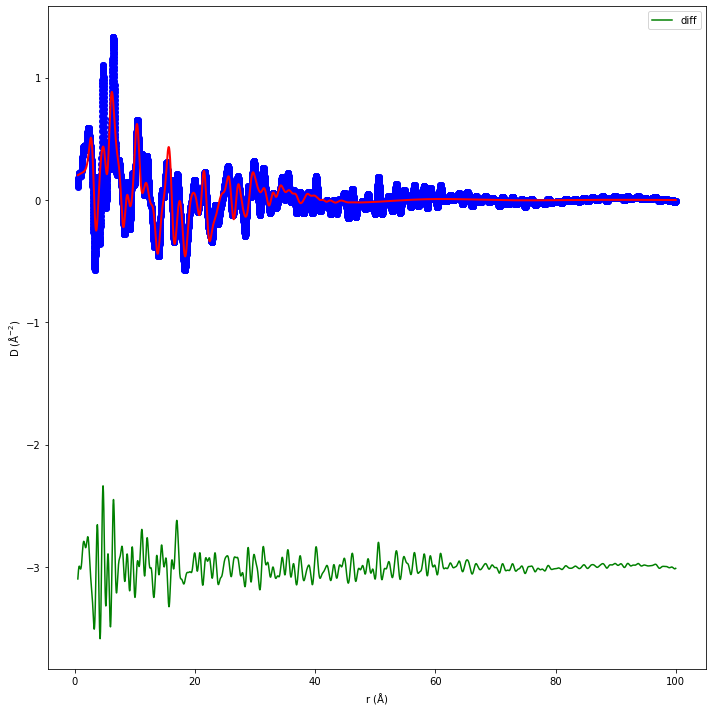

In [13]:
p0 = np.array([0.05239202,0.05480047,0.00111606,40,0.5,0.2,0.06,0.06])
opt = least_squares(residual,p0)
print(opt.x)

fit = calculate(opt.x)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_xlabel(r'r ($\mathdefault{\AA}$)')
ax.set_ylabel(r'D ($\mathdefault{\AA^{-2}}$)')

ax.plot(rexp,dexpSmooth,'bo',ls='--')
ax.plot(rexp,fit,'r-',lw=2)
ax.plot(rexp,dexpSmooth-fit-3,'g-',label='diff')
print(np.sqrt(np.sum((dexpSmooth-fit)**2)/np.sum(dexpSmooth**2)))
plt.tight_layout()
plt.legend()
plt.show()

In [14]:
np.savetxt('fit_drypowder_cubic.txt',np.column_stack((rexp,dexpSmooth,fit, dexpSmooth-fit)))

In [15]:
def getStdUnc(fitResult, data, dataErr=None, numConstraints=0):
    """Return the standard uncertainty of refined parameters.
    This method is based on the scipy.optimize.least_squares routine.
    Args:
        fitResult: Output from scipy.optimize.least_squares routine
        data (numpy array): The data against which the fit is performed
        dataErr (numpy array): Experimental uncertainties on the data points
            (set to unity if not provided)
        numConstraints (int): Number of constraints used in the model
    Returns:
        pUnc (numpy array): standard uncertainties of the refined parameters.
        chisq (float): Value of chi^2 for the fit.
    """
    if dataErr is None:
        dataErr = np.ones_like(data)
    weights = 1.0 / dataErr ** 2
    Rw = np.sqrt((fitResult.fun ** 2).sum() / (data ** 2 * weights).sum())
    numParams = len(fitResult.x)
    Rexp = np.sqrt((data.shape[0] - numParams + numConstraints) / (data ** 2 * weights).sum())
    j = fitResult.jac
    jac = np.dot(j.transpose(), j)
    cov = np.linalg.inv(jac) * Rw ** 2 / Rexp ** 2
    pUnc = np.sqrt(cov.diagonal())
    chisq = Rw ** 2 / Rexp ** 2
    return pUnc, chisq

In [16]:
getStdUnc(opt,dexpSmooth)

(array([0.0016449 , 0.00237761, 0.00107742, 0.54085383, 0.00907768,
        0.00177582, 0.02484097, 0.0018092 ]),
 0.010192712210237879)

In [17]:
### determine the ordered moment

nucScale = 1.1540 ### refined nuclear scale factor taken from PDFgui
sclA, sclB = opt.x[:2]
esclA,esclB = getStdUnc(opt,dexp)[0][:2]
print(sclA, esclA)
print(sclB, esclB)

### Calculate the average nuclear scattering length
import periodictable as pt ### useful python package included in your installation of diffpy.mpdf
bFe = pt.Fe.neutron.b_c
bO = pt.O.neutron.b_c
bAvg = (2.0*bFe+3.0*bO)/5.0

### define the ratio of magnetic atoms to total atoms in MnO
ns = 0.4

### determine the nominal spin magnitude from your structure
Snom = (8.0*sclA+16.*sclB*0.83333)/(8.0+13.333333)
eSnom = (8.0*esclA+16.*esclB*0.83333)/(8.0+13.333333)
### calculate the refined value of the ordered moment
Sfit = 2*np.sqrt(1.0*bAvg**2/(nucScale*ns))*Snom
eSfit = 2*np.sqrt(1.0*bAvg**2/(nucScale*ns))*eSnom
print(Sfit,eSfit)

SnomA = sclA
eSnomA = esclA
### calculate the refined value of the ordered moment
SfitA = 2*np.sqrt(1.0*bAvg**2/(nucScale*ns))*SnomA
eSfitA = 2*np.sqrt(1.0*bAvg**2/(nucScale*ns))*eSnomA
print(SfitA,eSfitA)


SnomB = sclB
eSnomB = esclB
### calculate the refined value of the ordered moment
SfitB = 2*np.sqrt(1.0*bAvg**2/(nucScale*ns))*SnomB
eSfitB = 2*np.sqrt(1.0*bAvg**2/(nucScale*ns))*eSnomB
print(SfitB,eSfitB)

0.16000385325254823 0.0016448999541920693
0.2300416706290796 0.002377612888121878
4.356805051604818 0.044959274262434894
3.420925224163952 0.035168401448682995
4.918352512559262 0.05083400016270483
